In [ ]:
  # Check Python version (Colab typically has a compatible version)
!python --version

# Check TensorFlow version
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Install additional required packages
!pip install pyttsx3 gTTS


Python 3.11.12
TensorFlow version: 2.18.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create a directory for your project
!mkdir -p /content/drive/MyDrive/TunisianDinarRecognition


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone Microsoft's BankNote-Net repository
!git clone https://github.com/microsoft/banknote-net.git

fatal: destination path 'banknote-net' already exists and is not an empty directory.


In [ ]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download the ZIP file from Google Drive using gdown with --fuzzy to handle share URLs
!gdown --fuzzy 'was a link to data of bills' -O /content/bills_dataset.zip

# Step 3: Unzip the contents (if the ZIP file is valid)
!unzip -q /content/bills_dataset.zip -d /content/inputData

# Step 4: (Optional) Check folder structure
!ls /content/inputData


Downloading...
From (original): https://drive.google.com/uc?id=1TxV8qiDVCDGBusThpRZOD-nOrPg-1IIR
From (redirected): https://drive.google.com/uc?id=1TxV8qiDVCDGBusThpRZOD-nOrPg-1IIR&confirm=t&uuid=3e5cb6bc-09d3-45cc-afc3-f50f7faa7db0
To: /content/bills_dataset.zip
100% 414M/414M [00:08<00:00, 49.2MB/s]
data


In [ ]:
# Set the path to your dataset in Drive
dataset_path = '/content/inputData/data'

# Create directories if they don't exist
!mkdir -p {dataset_path}/5dt
!mkdir -p {dataset_path}/10dt
!mkdir -p {dataset_path}/20Dt
!mkdir -p {dataset_path}/50dt


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
dataset_path = '/content/inputData/data'  # Update this path

# Create image data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Set image dimensions for BankNote-Net (224x224)
img_width, img_height = 224, 224
batch_size = 32

# Prepare the training generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Prepare the validation generator
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Display some class information
print(f"Class indices: {train_generator.class_indices}")


Found 479 images belonging to 4 classes.
Found 118 images belonging to 4 classes.
Class indices: {'10dt': 0, '20Dt': 1, '50dt': 2, '5dt': 3}


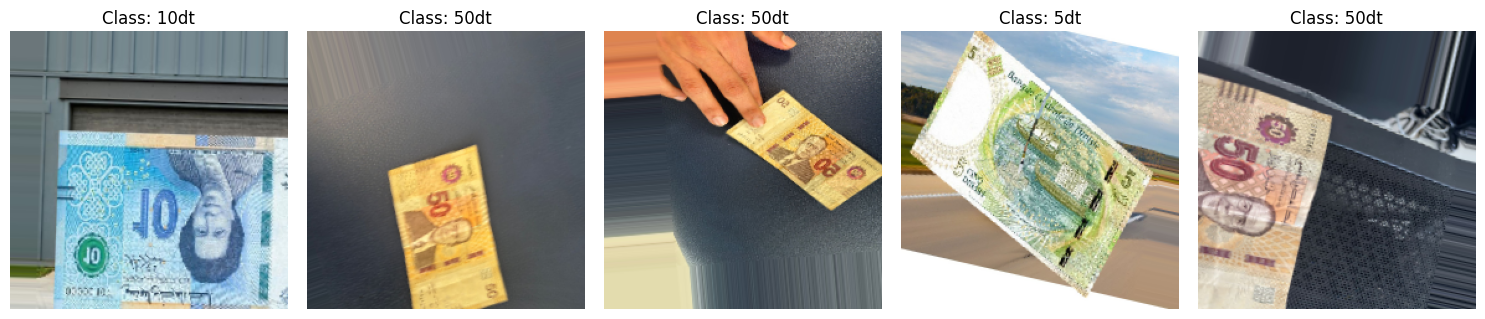

In [ ]:
# Function to plot images from a generator
def plot_images_from_generator(generator, num_images=5):
    plt.figure(figsize=(15, 3*num_images))

    # Get class mapping
    labels = list(generator.class_indices.keys())

    # Get a batch
    images, y_batch = next(generator)

    for i in range(num_images):
        plt.subplot(num_images, 5, i+1)
        plt.imshow(images[i])
        class_idx = np.argmax(y_batch[i])
        plt.title(f"Class: {labels[class_idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display training images
plot_images_from_generator(train_generator)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

# Check if there's already a pre-trained BankNote-Net encoder
try:
    encoder_path = "/content/banknote-net/models/banknote_net_encoder.h5"
    base_model = load_model(encoder_path)
    print("Loaded BankNote-Net encoder")
except:
    print("BankNote-Net encoder not found, creating MobileNetV2 base model")
    # If encoder is not available, use standard MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_width, img_height, 3)
    )

# Add custom classifier for Tunisian Dinar
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes for 5DT, 10DT, 20DT, 50DT

model = Model(inputs=base_model.input, outputs=predictions)

# Optional: Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


BankNote-Net encoder not found, creating MobileNetV2 base model
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
base_dir = '/content/inputData/data'
output_dir = '/content/data/split_data'
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'validation')

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Get all class directories
classes = [cls for cls in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, cls))]

# Loop through each class and split files
for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    images = os.listdir(class_dir)

    # Split images into train and validation sets (80-20 split)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Create class subdirectories in train and validation directories
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Move training images
    for img in train_images:
        src = os.path.join(class_dir, img)
        dest = os.path.join(train_dir, cls, img)
        shutil.copy(src, dest)

    # Move validation images
    for img in val_images:
        src = os.path.join(class_dir, img)
        dest = os.path.join(val_dir, cls, img)
        shutil.copy(src, dest)

print(f"Dataset split completed. Training data in {train_dir}, Validation data in {val_dir}")

Dataset split completed. Training data in /content/data/split_data/train, Validation data in /content/data/split_data/validation


Found 476 images belonging to 4 classes.
Found 121 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
13/15 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.2411 - loss: 1.4053   
Epoch 1: val_accuracy improved from -inf to 0.27273, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2473 - loss: 1.4015 - val_accuracy: 0.2727 - val_loss: 1.3218
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3755 - loss: 1.3082
Epoch 2: val_accuracy improved from 0.27273 to 0.43802, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3784 - loss: 1.3060 - val_accuracy: 0.4380 - val_loss: 1.1905
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4958 - loss: 1.1375
Epoch 3: val_accuracy improved from 0.43802 to 0.49587, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4981 - loss: 1.1351 - val_accuracy: 0.4959 - val_loss: 1.0218
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5626 - loss: 1.0040   
Epoch 4: val_accuracy improved from 0.49587 to 0.66116, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5622 - loss: 1.0048 - val_accuracy: 0.6612 - val_loss: 0.8189
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6603 - loss: 0.8958
Epoch 5: val_accuracy improved from 0.66116 to 0.71901, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6588 - loss: 0.8940 - val_accuracy: 0.7190 - val_loss: 0.7634
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6817 - loss: 0.8124
Epoch 6: val_accuracy improved from 0.71901 to 0.76860, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6809 - loss: 0.8107 - val_accuracy: 0.7686 - val_loss: 0.6434
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6706 - loss: 0.7593
Epoch 7: val_accuracy improved from 0.76860 to 0.80992, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.6717 - loss: 0.7578 - val_accuracy: 0.8099 - val_loss: 0.5561
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7660 - loss: 0.6598
Epoch 8: val_accuracy improved from 0.80992 to 0.85124, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7658 - loss: 0.6594 - val_accuracy: 0.8512 - val_loss: 0.4972
Epoch 9/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7641 - loss: 0.6121
Epoch 9: val_accuracy did not improve from 0.85124
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7630 - loss: 0.6147 - val_accuracy: 0.7190 - val_loss: 0.6525
Epoch 10/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7769 - loss: 0.6441
Epoch 10: val_accuracy did not improve from 0.85124
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.7775 - loss: 0.6421 - val_accuracy: 0.8512 - val_loss: 0.4553
Epoch 11/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7805 - loss: 0.5408
Epoch 11: val_accuracy did not improve from 0.85124
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7809 - loss: 0.5409 - val_accuracy: 0.8264 - val_loss: 0.4436
Epoch 12/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.7502 - loss: 0.6067
Epoch 12: val_accuracy improved from 0.85124 to

15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7511 - loss: 0.6041 - val_accuracy: 0.8926 - val_loss: 0.3849
Epoch 13/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8173 - loss: 0.5031
Epoch 13: val_accuracy did not improve from 0.89256
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8174 - loss: 0.5022 - val_accuracy: 0.8430 - val_loss: 0.4281
Epoch 14/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8389 - loss: 0.4557
Epoch 14: val_accuracy improved from 0.89256 to 0.90909, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8381 - loss: 0.4564 - val_accuracy: 0.9091 - val_loss: 0.3497
Epoch 15/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8318 - loss: 0.4722
Epoch 15: val_accuracy did not improve from 0.90909
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8315 - loss: 0.4725 - val_accuracy: 0.9091 - val_loss: 0.3241
Epoch 16/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8396 - loss: 0.4223
Epoch 16: val_accuracy did not improve from 0.90909
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8392 - loss: 0.4235 - val_accuracy: 0.9091 - val_loss: 0.3115
Epoch 17/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8732 - loss: 0.3840
Epoch 17: val_accuracy did not improve from 0.90909
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8727 - loss: 0.3853 - val_accuracy: 0.9091 - val_loss: 0.2921
Epoch 18/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8575 - loss: 0.3716
Epoch 18: val_accuracy did not improve from 0.90

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8322 - loss: 0.4507 - val_accuracy: 0.9256 - val_loss: 0.2697
Epoch 21/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8876 - loss: 0.3248
Epoch 21: val_accuracy improved from 0.92562 to 0.94215, saving model to /content/drive/MyDrive/TunisianDinarRecognition/best_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8870 - loss: 0.3258 - val_accuracy: 0.9421 - val_loss: 0.2355
Epoch 22/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9189 - loss: 0.3312   
Epoch 22: val_accuracy did not improve from 0.94215
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9174 - loss: 0.3314 - val_accuracy: 0.9339 - val_loss: 0.2148
Epoch 23/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8670 - loss: 0.3482
Epoch 23: val_accuracy did not improve from 0.94215
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8674 - loss: 0.3470 - val_accuracy: 0.9091 - val_loss: 0.2174
Epoch 24/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8821 - loss: 0.3172
Epoch 24: val_accuracy did not improve from 0.94215
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8819 - loss: 0.3185 - val_accuracy: 0.9256 - val_loss: 0.2372
Epoch 25/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8758 - loss: 0.3263
Epoch 25: val_accuracy did not improve from 0

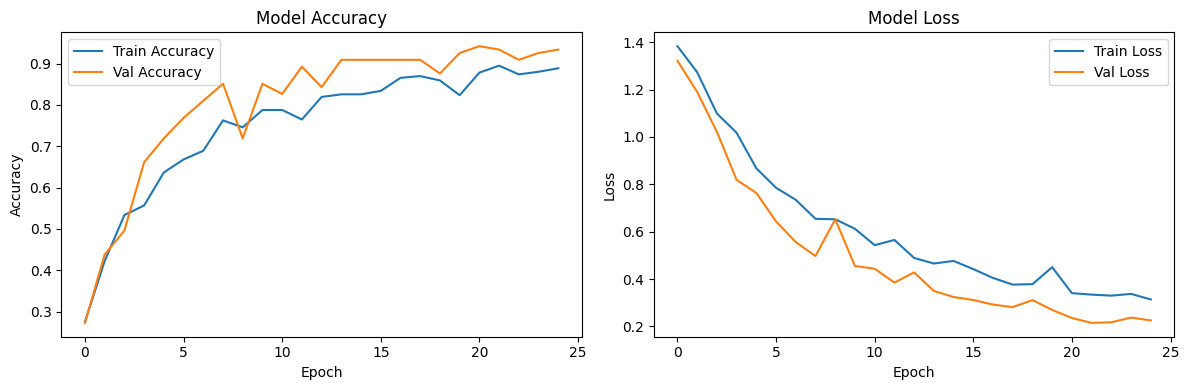

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set paths
base_dir = '/content/data/split_data'  # This should match where your split data is stored
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Image dimensions
img_height, img_width = 150, 150
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Get number of classes dynamically
num_classes = train_generator.num_classes

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/TunisianDinarRecognition/best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model
# Train the model without specifying steps_per_epoch or validation_steps
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[checkpoint, early_stopping]
)

# Save final model
model.save('/content/drive/MyDrive/TunisianDinarRecognition/tunisian_dinar_model.h5')

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

# Generate predictions on a few samples
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict_image(img_path):
    # Define class labels based on your data
    class_labels = list(train_generator.class_indices.keys())

    # Preprocess and predict
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]

    # Display results
    plt.imshow(image.load_img(img_path, target_size=(img_width, img_height)))
    plt.title(f"Predicted: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

    return class_labels[predicted_class], confidence

# Test with a few images (if available)
# predict_image('/path/to/test/image.jpg')


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step - accuracy: 0.9152 - loss: 0.2180
Validation Loss: 0.2148
Validation Accuracy: 0.9339


In [ ]:
# Using gTTS for text-to-speech in Colab (pyttsx3 needs special setup in Colab)
from gtts import gTTS
from IPython.display import Audio

def announce_denomination(denomination):
    """Generate speech for a detected denomination"""
    text = f"This is a {denomination} bill"
    tts = gTTS(text)

    # Save and play the audio
    tts.save('announcement.mp3')
    return Audio('announcement.mp3', autoplay=True)

# Test the TTS
# announce_denomination("10 Dinar")


In [ ]:
"""
NOTE: This code is for reference and will work when deployed locally.
Colab doesn't have direct access to your webcam for live video.
"""

def recognize_currency_live_code():
    """
    This is reference code for when you deploy the model locally.
    It won't run directly in Colab but shows how to implement the webcam recognition.
    """
    import cv2

    # Load the model
    model = tf.keras.models.load_model('tunisian_dinar_model.h5')

    # Define class labels (match your dataset folder names)
    class_labels = ["5DT", "10DT", "20DT", "50DT"]

    # Start webcam
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Display frame
        cv2.imshow('Currency Recognition', frame)

        # Process when spacebar is pressed
        key = cv2.waitKey(1)
        if key == 32:  # Spacebar
            # Resize frame to model input size
            img = cv2.resize(frame, (224, 224))

            # Preprocess for model
            img_array = np.expand_dims(img, axis=0) / 255.0

            # Make prediction
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions[0])
            confidence = predictions[0][predicted_class]

            # Get denomination
            denomination = class_labels[predicted_class]

            # Display result
            cv2.putText(frame, f"{denomination} ({confidence:.2f})",
                       (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imshow('Currency Recognition', frame)

            # Text-to-speech announcement would go here
            print(f"Detected: {denomination}")

        # Exit on ESC
        elif key == 27:  # ESC
            break

    cap.release()
    cv2.destroyAllWindows()

# This is just reference code for local deployment
# Don't try to run it directly in Colab


In [ ]:
# Convert the model to TensorFlow Lite format for mobile deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model
with open('/content/drive/MyDrive/TunisianDinarRecognition/tunisian_dinar_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpgrsh4gyw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_158')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137451707777680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707779216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707778640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707779984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707779408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707780752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707780176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707781520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707780944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137451707782288: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
#to download model
"""from google.colab import files
files.download('/content/drive/MyDrive/TunisianDinarRecognition/tunisian_dinar_model.h5')
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#download json containing the type of output neuron
"""import json

# Save the class indices dictionary as a JSON file in Colab
class_indices = train_generator.class_indices
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)
from google.colab import files

# Download class indices file
files.download('class_indices.json')
"""

"import json\n\n# Save the class indices dictionary as a JSON file in Colab\nclass_indices = train_generator.class_indices\nwith open('class_indices.json', 'w') as f:\n    json.dump(class_indices, f)\nfrom google.colab import files\n\n# Download class indices file\nfiles.download('class_indices.json')\n"